In [1]:
import json
import zipfile
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
import csv
%matplotlib inline

In [2]:
# we need formaula to compute distance between two points

#Since the distance is relatively small, you can use the equirectangular distance approximation
def haversine(point1, point2):
    # radius of the earth in km
    R = 6371 
    # get lat and lon
    lon1, lat1 = point1[0], point1[1]
    lon2, lat2 = point2[0], point2[1]
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(math.radians, [lon1, lat1, lon2, lat2])
    # formula
    x = (lon2 - lon1) * math.cos( 0.5*(lat2+lat1) )
    y = lat2 - lat1
    d = R * math.sqrt( x*x + y*y )
    return d


In [3]:
# Longitude and latitude coordinates of Porto
point_mid = [-8.6109900, 41.1496100] #lon, lat

#Porto airport coordinates
point_air = [-8.671403, 41.237137]

## 1. Data loading and selection

In [12]:
# Load the data
#zf = zipfile.ZipFile('train.csv.zip')
df = pd.read_csv('train.csv', 
                 sep = ",",
                 chunksize = 1000,
                 iterator = True,
                 usecols = ['POLYLINE', 'MISSING_DATA'],
                 converters={'POLYLINE': lambda x: json.loads(x)})

In [13]:
initial_radius = 1.5 #km
#df_airport = pd.DataFrame()

In [14]:
traj_df = pd.DataFrame()

for data in df:
    #print data
    for index, row in data.iterrows():
        if len(row["POLYLINE"]) > 0:
            if haversine(row["POLYLINE"][0], point_air) <= initial_radius:
                row['Destination'] = row['POLYLINE'][-1]
                traj_df = traj_df.append(row, ignore_index=True)

In [60]:
air_traj_list = []
for data in df:
    #print data['POLYLINE']
    for coords in data['POLYLINE']:
        if len(coords) > 0:
            if haversine(coords[0], point_air) <= initial_radius:
                #print "Yes"
                air_traj_list.append(coords)
                
    break
    

In [22]:
traj_df['MISSING_DATA'].value_counts()

0    4328
Name: MISSING_DATA, dtype: int64

In [23]:
traj_df.to_csv('air_trajs.csv')
#df.to_csv(file_name, sep='\t')

In [50]:
with open("air_traj.csv", "wb") as f:
    writer = csv.writer(f, delimiter=',',
                        quotechar='|', quoting=csv.QUOTE_MINIMAL)
    writer.writerows(air_traj_list)

In [86]:
# Let's see end points of selected trips

In [130]:
start_points = np.array([trip[0] for trip in air_traj_list])
end_points = np.array([trip[-1] for trip in air_traj_list])
latlong = end_points.copy()

In [101]:
# cut off long distance trips
lat_low, lat_hgh = np.percentile(latlong[:,0], [2, 98])
lon_low, lon_hgh = np.percentile(latlong[:,1], [2, 98])

# create image
bins = 513
lat_bins = np.linspace(lat_low, lat_hgh, bins)
lon_bins = np.linspace(lon_low, lon_hgh, bins)
H2, _, _ = np.histogram2d(latlong[:,0], latlong[:,1], bins=(lat_bins, lon_bins))

img = np.log(H2[::-1, :] + 1)

plt.figure()
ax = plt.subplot(1,1,1)
plt.imshow(img)
plt.axis('off')
plt.title('Taxi trip end points')
plt.savefig("taxi_trip_end_points.png")

In [131]:
start_lats = [p[1] for p in start_points]
start_lons = [p[0] for p in start_points]

end_lats = [p[1] for p in end_points]
end_lons = [p[0] for p in end_points]


In [135]:
import gmplot

gmap = gmplot.GoogleMapPlotter(41.1496100, -8.6109900 , 12)

#gmap.plot(heat_lats, heat_lons, 'cornflowerblue', edge_width=10)
#gmap.scatter(heat_lats, heat_lons, '#3B0B39', size=10, marker=False)
gmap.scatter(start_lats, start_lons, '#006400', size=10, marker=False)
gmap.scatter(end_lats, end_lons, '#8B0000', size=10, marker=False)

#gmap.heatmap(heat_lats, heat_lons)

gmap.draw("mymap.html")

## 2. Work with extracted data

In [4]:
air_trajs = pd.read_csv('air_trajs.csv',
                        #index_col=,
                        usecols = ['POLYLINE', 'Destination'],
                        converters={'POLYLINE': lambda x: json.loads(x), 'Destination': lambda x: json.loads(x)})

In [5]:
decision_points = []
end_points = np.array([trip[-1] for trip in air_trajs['POLYLINE']])
start_points = np.array([trip[0] for trip in air_trajs['POLYLINE']])

In [6]:
def mean_points_alpha(points):
    lats = [point[0] for point in points]
    lons = [point[1] for point in points]
    return [np.mean(lats), np.mean(lons)]

def sqare_error_alpha(points):
    pmean = mean_points_alpha(points)
    #print np.mean(np.power([haversine(point, pmean) for point in points], 2))
    return np.mean(np.power([haversine(point, pmean) for point in points], 2))
    
def index_points_in_circe(center, radius, points):
    indexes = []
    for index, point in points.iteritems():
        if haversine(center, point) <= radius:
            indexes.append(index)
            
    return indexes


In [88]:
index_points_in_circe(start_points[4], 0.001, air_trajs['Destination'])

[]

In [56]:
def find_decision_point(trajs, targets):
    eps = 0.001
    metric = {}
    
    
    start_points = trajs.copy()
    for index, row in start_points.iteritems():
        start_points[index] = row[0]
    
    for point in start_points[1:2]:
        p_metrics = []
        nn = 1
        radius = eps
        print 'start'
        
        sigma = []
        neighbors = []
        
        while(nn < len(start_points)):
            print nn, len(start_points)
            n_indexes = index_points_in_circe(point, radius, start_points)
            if nn < len(n_indexes):
                nn = len(n_indexes)
                print 'yes', nn, radius
                
                sigma.append(sqare_error_alpha(targets[n_indexes]))
                neighbors.append(nn)
                
                metric = sqare_error_alpha(targets[n_indexes])/nn
                p_metrics.append(metric)
                radius += eps
            else:
                print 'no', radius
                radius += eps
         
        #metric[start_points[start_points == point].index[0]] = min(p_metrics)
        print len(p_metrics)
        print min(p_metrics), p_metrics.index(min(p_metrics))
        print metric
    
    #print len(p_metrics), p_metrics
    return sigma, neighbors
    

In [57]:
sigmas, neighbors = find_decision_point(air_trajs['POLYLINE'], air_trajs['Destination'])

start
1 4328
no 0.001
1 4328
no 0.002
1 4328
no 0.003
1 4328
yes 2 0.004
2 4328
yes 4 0.005
4 4328
no 0.006
4 4328
yes 5 0.007
5 4328
yes 8 0.008
8 4328
yes 9 0.009
9 4328
yes 10 0.01
10 4328
yes 12 0.011
12 4328
yes 14 0.012
14 4328
yes 17 0.013
17 4328
yes 20 0.014
20 4328
yes 23 0.015
23 4328
yes 25 0.016
25 4328
yes 27 0.017
27 4328
yes 28 0.018
28 4328
yes 31 0.019
31 4328
no 0.02
31 4328
yes 32 0.021
32 4328
yes 34 0.022
34 4328
yes 42 0.023
42 4328
yes 45 0.024
45 4328
yes 49 0.025
49 4328
yes 62 0.026
62 4328
yes 71 0.027
71 4328
yes 76 0.028
76 4328
yes 90 0.029
90 4328
yes 100 0.03
100 4328
yes 109 0.031
109 4328
yes 123 0.032
123 4328
yes 134 0.033
134 4328
yes 145 0.034
145 4328
yes 153 0.035
153 4328
yes 164 0.036
164 4328
yes 172 0.037
172 4328
yes 181 0.038
181 4328
yes 198 0.039
198 4328
yes 204 0.04
204 4328
yes 210 0.041
210 4328
yes 219 0.042
219 4328
yes 231 0.043
231 4328
yes 243 0.044
243 4328
yes 258 0.045
258 4328
yes 266 0.046
266 4328
yes 276 0.047
276 4328
ye

In [65]:
x = range(len(sigmas))
sigmas = np.array(sigmas)
neighbors = np.array(neighbors)
print np.where(np.log(sigmas)/neighbors==min(np.log(sigmas)/neighbors))
print np.where(np.log(sigmas/neighbors)==min(np.log(sigmas/neighbors)))
print np.where(sigmas/np.log(neighbors)==min(sigmas/np.log(neighbors)))

(array([890]),)
(array([890]),)
(array([1]),)


In [60]:
neighbors.shape

(891,)

In [62]:
print np.where(sigmas==min(sigmas))

(array([0]),)


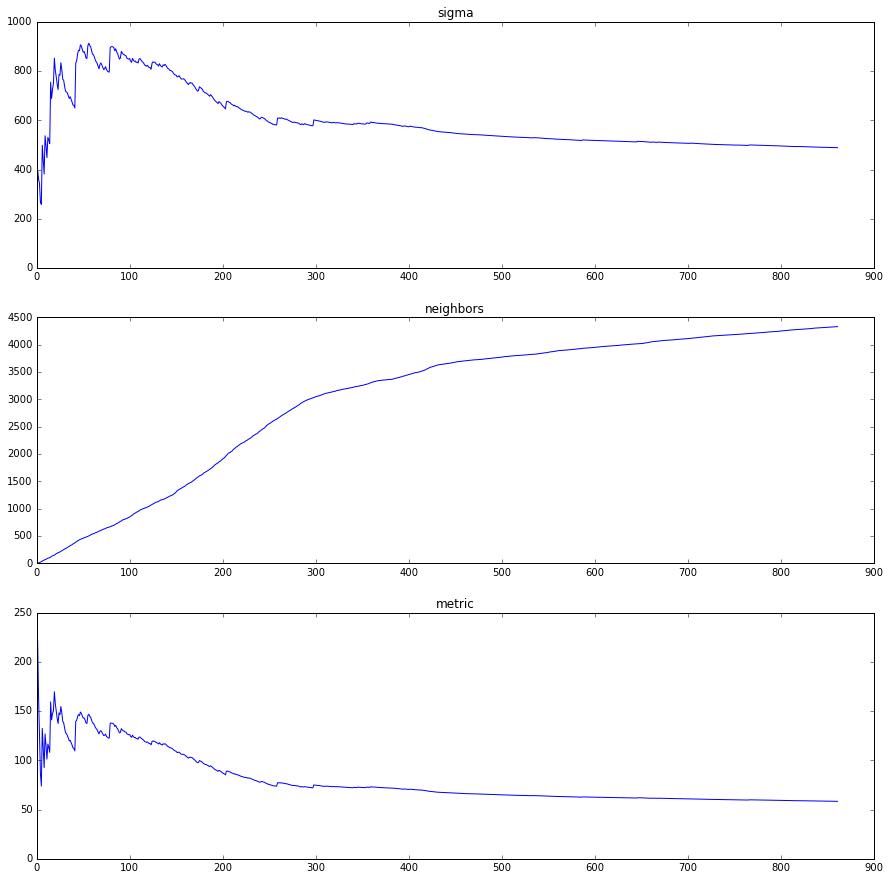

In [50]:
plt.figure(1, figsize=(15,15))
plt.subplot(311)
plt.title('sigma')
plt.plot(x, sigmas)

plt.subplot(312)
plt.title('neighbors')
plt.plot(x, neighbors)

plt.subplot(313)
plt.title('metric')
plt.plot(x, sigmas/np.log(neighbors))

plt.show()

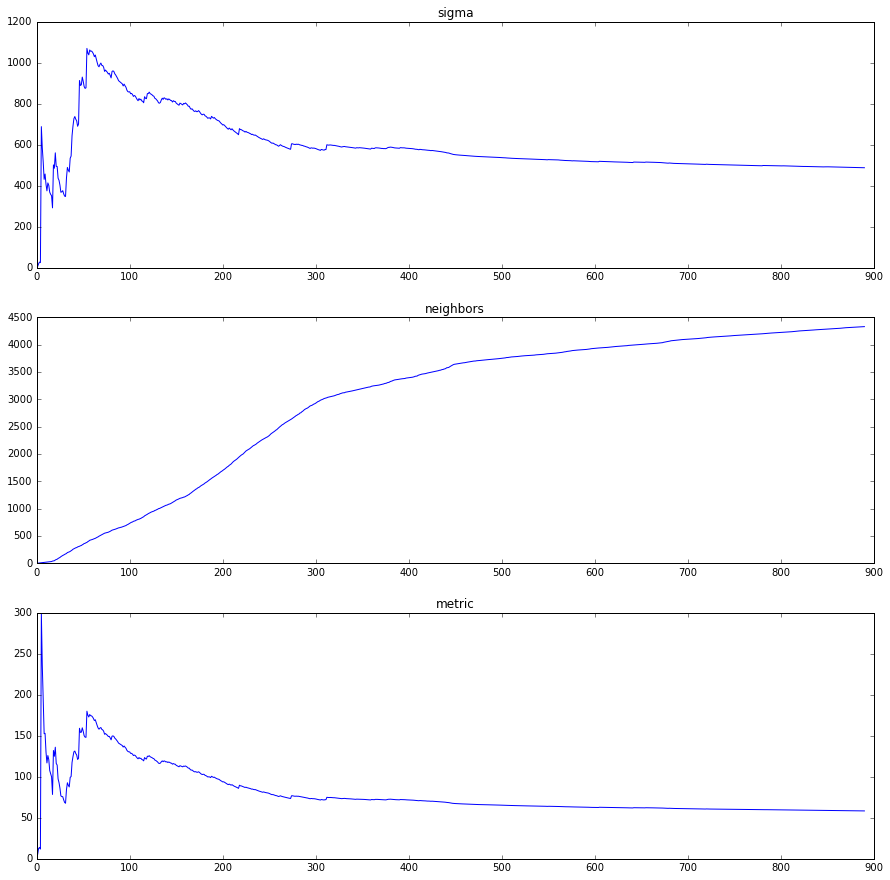

In [66]:
plt.figure(1, figsize=(15,15))
plt.subplot(311)
plt.title('sigma')
plt.plot(x, sigmas)

plt.subplot(312)
plt.title('neighbors')
plt.plot(x, neighbors)

plt.subplot(313)
plt.title('metric')
plt.plot(x, sigmas/np.log(neighbors))

plt.show()

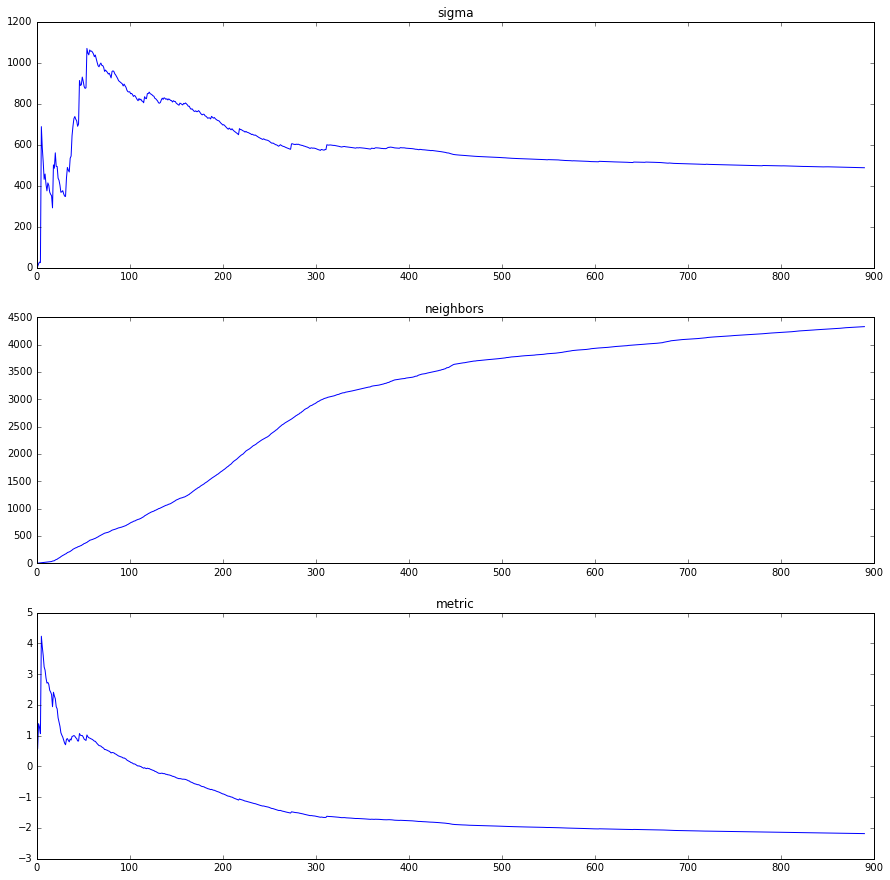

In [68]:
plt.figure(1, figsize=(15,15))
plt.subplot(311)
plt.title('sigma')
plt.plot(x, sigmas)

plt.subplot(312)
plt.title('neighbors')
plt.plot(x, neighbors)

plt.subplot(313)
plt.title('metric')
plt.plot(x, np.log(sigmas/neighbors))

plt.show()